In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr
from sklearn import linear_model, metrics, svm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Feature Description
#CensusTract, SchoolYear, GradeLevel, Count given from DOE. SchoolYear 0 means Grade K

###Added features###
#TotalCount = Total number of students for a given year across all tract and grade
#TotalCountByGrade = Total number of students for a given year and grade across all tract
#TotalCountByTract = Total number of students for a given year and tract across all grade
#TotalCountByZip = Total number of studetns for a given year and zip across all grade
#TotalCountByZipGrade = Total number of students for a given year, zip and grade
#TotalCountByTractGrade = Same as Count // can be removed
#PrevGradeCount = Total number of students from prior grade for a given yaer and tract
#e.g, for year 2010, tract 18, grade 5, its PrevGradeCount will be Count from year 2010, tract 18 and grade 4
#PrevGradeCountmavg3 = 3 year average of PrevGradeCount
#PrevGradeCountmavg5 = 5 year average of PreveGradeCount
#OneYearGrowth = one year growth rate of Count for a given tract and grade
#ThreeYearGrowth = three year growth rate of Count for a given tract and grade
#OneYearGrowthmavg3 = 3 year average of OneYearGrowth
#ThreeYearGrowthmavg3 = 3 year average of ThreeYearGrowth
#Y = Target variable 1 = Increase in count in the next year, 0 = decrease/stay the same in the next year

##We can ignore Target,Y2 columns in newt.csv // I will clean up later
df = pd.read_csv('cleantable-mb.csv')
df = df.fillna(0.0)
df = df[df.SchoolYear<2010]
df = df.drop(['Target','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns

In [4]:
def analysis(train_df_x, train_df_y, test_df_x, test_df_y):
    
    #Decision Tree
    clf = DecisionTreeClassifier(criterion='entropy')
    clf = clf.fit(train_df_x, train_df_y)

    feature_importances = clf.feature_importances_
    
    #Plot Feature importance
    plt.figure()
    plt.title('Feature Importances bar plot')
    plt.bar(range(train_df_x.shape[1]), feature_importances, align='center')
    plt.xticks(range(train_df_x.shape[1]), train_df_x.columns, rotation='vertical')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()
    plt.close("all")
    
    #Show top 5 features
    order = np.argsort(feature_importances)[::-1]
    print("Top 5 most important features")
    for n,i in enumerate(order[:5]):
        print("%d"%(n+1),train_df_x.columns[i],feature_importances[i])

    #Print Accuracy
    cm = confusion_matrix(clf.predict(train_df_x), train_df_y)
    print("\nAccuracy on train_df: ",(cm[0][0] + cm[1][1]) / float(sum(sum(cm))))
    cm2 = confusion_matrix(clf.predict(test_df_x), test_df_y)
    print("Accuracy on test_df: ",(cm2[0][0] + cm2[1][1]) / float(sum(sum(cm2))))
    
    #Try different parameters for DT
    min_samples_split_values = [round(int(len(train_df_x)*0.01*i),-1) for i in range(1,11,1)]#np.arange(300,3001,300)
    min_samples_leaf_values = [round(int(len(train_df_x)*0.05*i*0.1),-1) + 1 for i in range(1,11,1)]
    
    #print(min_samples_split_values)
    #print(min_samples_leaf_values)
    result = dict()

    for i in min_samples_split_values:

        result[i] = list()

        for j in min_samples_leaf_values:

            clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = j, min_samples_split= i)
            clf = clf.fit(train_df_x, train_df_y)
            cm = confusion_matrix(clf.predict(test_df_x), test_df_y)
            result[i].append((cm[0][0] + cm[1][1]) / float(sum(sum(cm))))
    
    #Plot accuracy of DT with different parameters
    plt.figure()
    colors = ['b','r','y','g','k','orange','c','m','pink','gray','firebrick']
    for n,i in enumerate(min_samples_split_values):
        plt.plot(min_samples_leaf_values, result[i], color = colors[n], label = 'Split={}'.format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Min Leaf Size')
    plt.ylabel('Accuracy from Confusion matrix')
    plt.title("Decision Tree with different min_leaf, min_split parameters")
    plt.show()
    plt.close("all")
    
    #Logistic regression
    logreg = linear_model.LogisticRegression(C = 1e30)
    logreg.fit(train_df_x, train_df_y)
    pred_lr = logreg.predict_proba(test_df_x)[:,1]

    fpr_lr, tpr_lr, thre_lr = metrics.roc_curve(test_df_y, pred_lr)
    roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
    
    #SVM Model
    my_svm = svm.SVC(kernel='linear')
    my_svm.fit(train_df_x, train_df_y)
    pred_svm = my_svm.decision_function(test_df_x)

    fpr_svm, tpr_svm, thre_svm = metrics.roc_curve(test_df_y, pred_svm)
    roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
    
    #Plot ROC curve for LogReg and SVM
    fig = plt.figure(figsize = (6, 5))
    plt.title('ROC Curve')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.plot([0,1],[0,1],'r--', label='')
    plt.plot(fpr_lr, tpr_lr, label='AUC log_reg({0:.3f})'.format(roc_auc_lr))
    plt.plot(fpr_svm, tpr_svm, label='AUC SVM({0:.3f})'.format(roc_auc_svm))
    plt.legend(loc=4)
    return pred_lr 


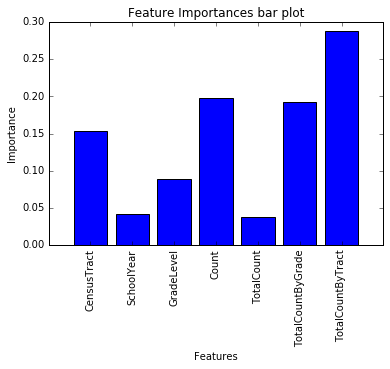

Top 5 most important features
1 TotalCountByTract 0.287219229964
2 Count 0.198126071496
3 TotalCountByGrade 0.192240602545
4 CensusTract 0.153619559319
5 GradeLevel 0.0893977612245

Accuracy on train_df:  1.0
Accuracy on test_df:  0.65826873385


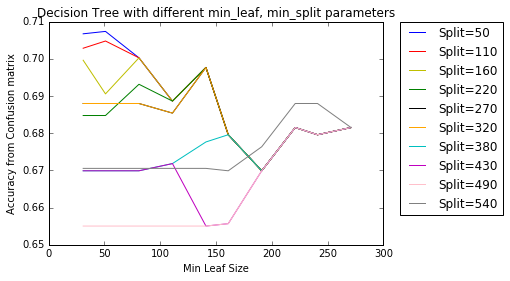

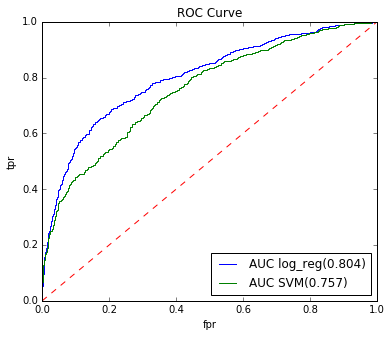

In [6]:
#Base model using very simple features
#TotalCount = Total number of students for a given year across all tract and grade
#TotalCountByGrade = Total number of students for a given year and grade across all tract
#TotalCountByTract = Total number of students for a given year and tract across all grade
test_df = df[df.SchoolYear>2007] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2007] # Training set from 2001 to 2007
train_df_x = train_df[['CensusTract','SchoolYear','GradeLevel','Count','TotalCount','TotalCountByGrade','TotalCountByTract']]
train_df_y = train_df.Y
test_df_x = test_df[['CensusTract','SchoolYear','GradeLevel','Count','TotalCount','TotalCountByGrade','TotalCountByTract']]
test_df_y = test_df.Y
a=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

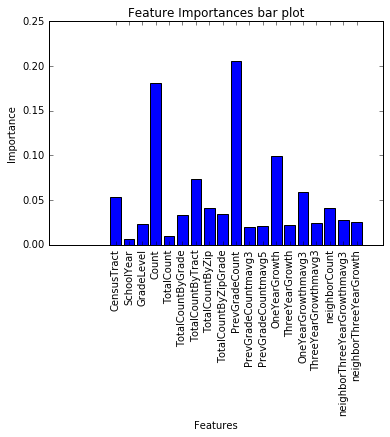

Top 5 most important features
1 PrevGradeCount 0.205836636035
2 Count 0.181012300958
3 OneYearGrowth 0.0994335793263
4 TotalCountByTract 0.0737874422795
5 OneYearGrowthmavg3 0.0584597479562

Accuracy on train_df:  1.0
Accuracy on test_df:  0.707393483709


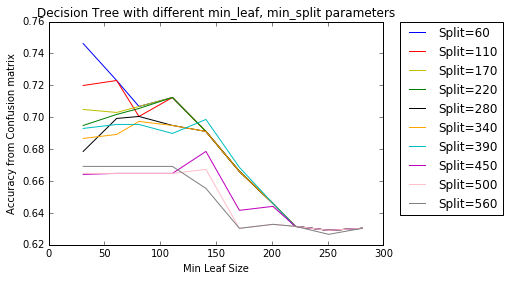

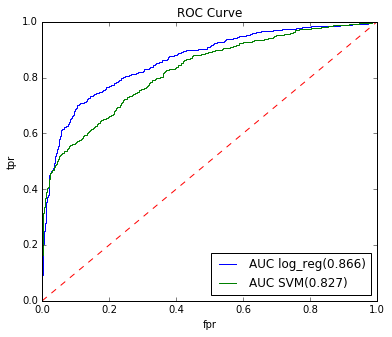

In [4]:
#Training year 2001,2002,2003,2004,2005,2006,2007
#Prediction for 2008 and 2009
test_df = df[df.SchoolYear>2007] 
train_df = df[df.SchoolYear<=2007]
train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
b=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

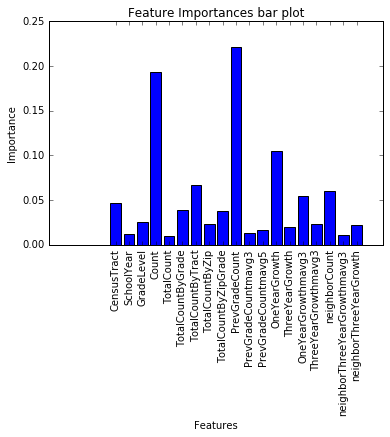

Top 5 most important features
1 PrevGradeCount 0.22174820859
2 Count 0.193124790837
3 OneYearGrowth 0.104324208352
4 TotalCountByTract 0.0669957103256
5 neighborCount 0.0601865131462

Accuracy on train_df:  1.0
Accuracy on test_df:  0.715956558062


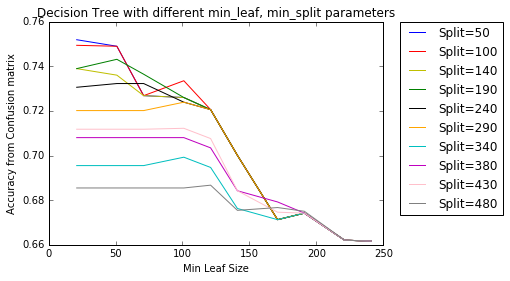

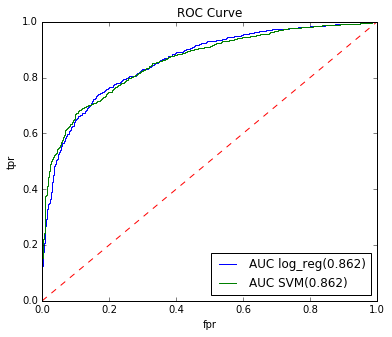

In [5]:
#Training year 2001,2002,2003,2004,2005,2006
#Prediction for 2007,2008 and 2009
test_df = df[df.SchoolYear>2006] 
train_df = df[df.SchoolYear<=2006] 

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
c=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

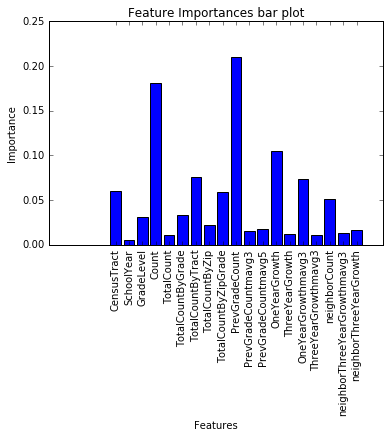

Top 5 most important features
1 PrevGradeCount 0.210293405377
2 Count 0.180657112161
3 OneYearGrowth 0.104817702429
4 TotalCountByTract 0.0754971164493
5 OneYearGrowthmavg3 0.0731341929255

Accuracy on train_df:  1.0
Accuracy on test_df:  0.72149122807


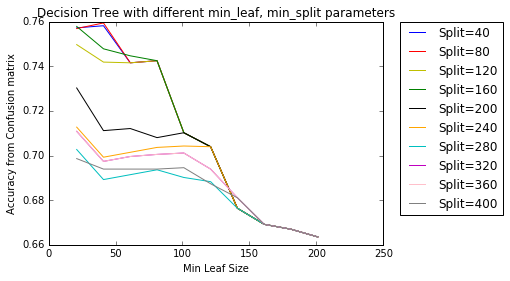

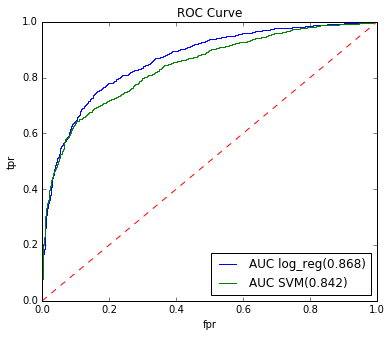

In [6]:
#Training year 2001,2002,2003,2004,2005
#Prediction for 2006,2007,2008 and 2009
test_df = df[df.SchoolYear>2005] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2005] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
d=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

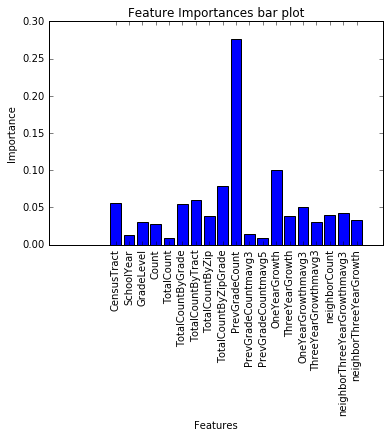

Top 5 most important features
1 PrevGradeCount 0.276714584335
2 OneYearGrowth 0.099841682616
3 TotalCountByZipGrade 0.0782523970208
4 TotalCountByTract 0.0601905237314
5 CensusTract 0.0564365923437

Accuracy on train_df:  1.0
Accuracy on test_df:  0.715867158672


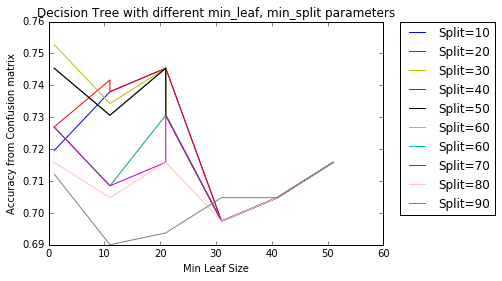

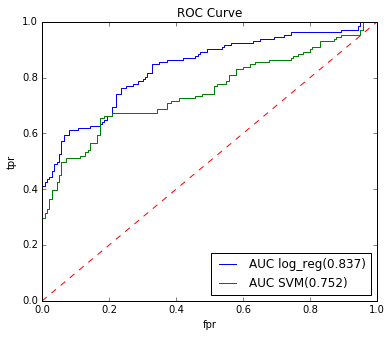

In [7]:
# Now we split the dataset by number of students
#Prediction for 2008 and 2009
#Data with <5 students
newdf = df[df.Count<5]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007
train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
e=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

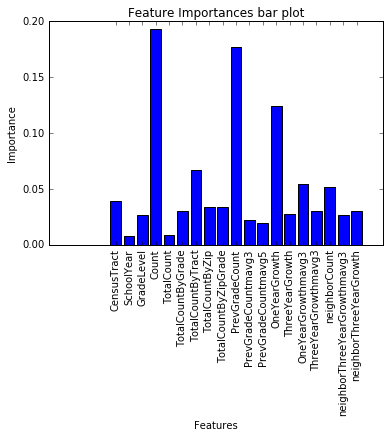

Top 5 most important features
1 Count 0.193276631978
2 PrevGradeCount 0.177167467009
3 OneYearGrowth 0.123717041029
4 TotalCountByTract 0.0667380097178
5 OneYearGrowthmavg3 0.0544129431721

Accuracy on train_df:  1.0
Accuracy on test_df:  0.678490566038


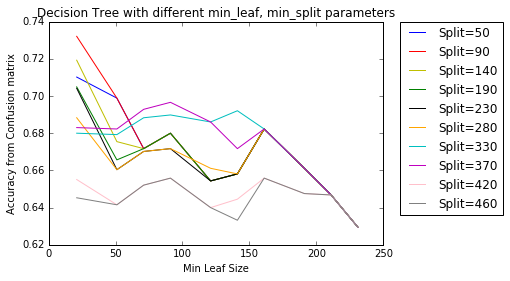

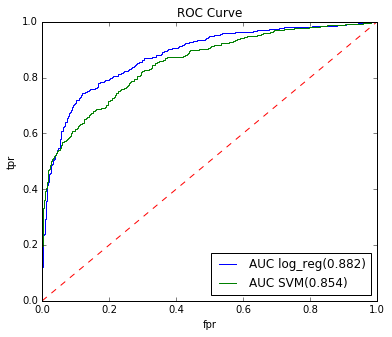

In [8]:
#Data with students >=5
newdf = df[df.Count>=5]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
f=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

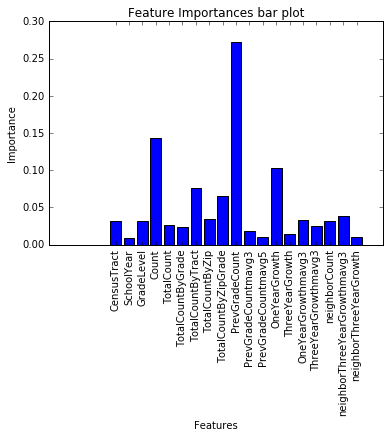

Top 5 most important features
1 PrevGradeCount 0.27246990743
2 Count 0.143364623135
3 OneYearGrowth 0.103210639661
4 TotalCountByTract 0.0766591792142
5 TotalCountByZipGrade 0.0650609351707

Accuracy on train_df:  1.0
Accuracy on test_df:  0.736625514403


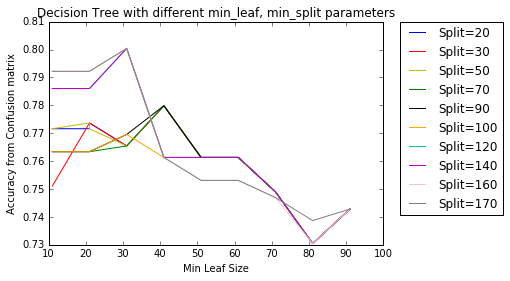

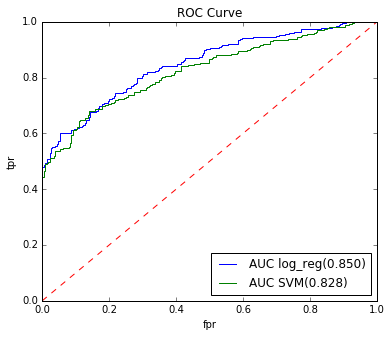

In [9]:
# Prediction for 2008 and 2009
#Data with <10 students
newdf = df[df.Count<10]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
g=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

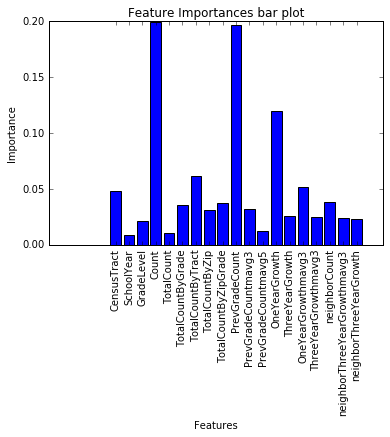

Top 5 most important features
1 Count 0.19912894708
2 PrevGradeCount 0.196842234595
3 OneYearGrowth 0.119446257796
4 TotalCountByTract 0.0615847401807
5 OneYearGrowthmavg3 0.0513501835732

Accuracy on train_df:  1.0
Accuracy on test_df:  0.720720720721


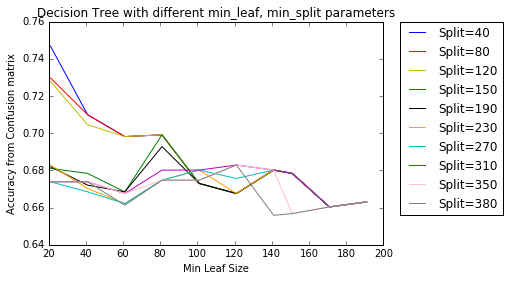

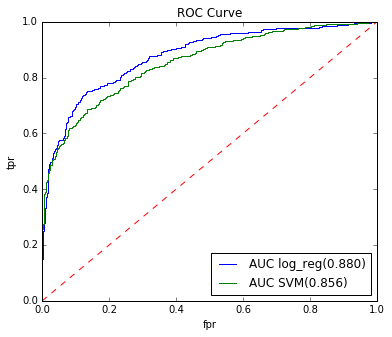

In [10]:
#Data with students >=10
newdf = df[df.Count>=10]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
h = analysis(train_df_x, train_df_y, test_df_x, test_df_y)

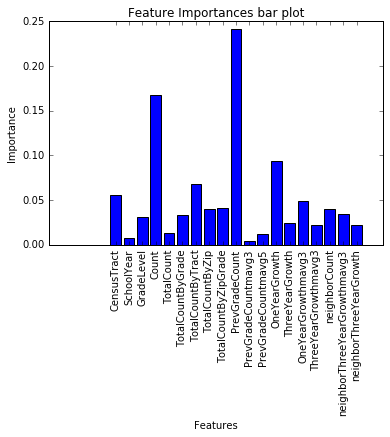

Top 5 most important features
1 PrevGradeCount 0.240914001128
2 Count 0.167987447806
3 OneYearGrowth 0.0940971081496
4 TotalCountByTract 0.0676570103667
5 CensusTract 0.0557180680613

Accuracy on train_df:  1.0
Accuracy on test_df:  0.716524216524


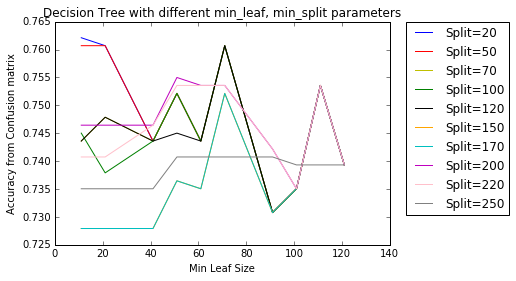

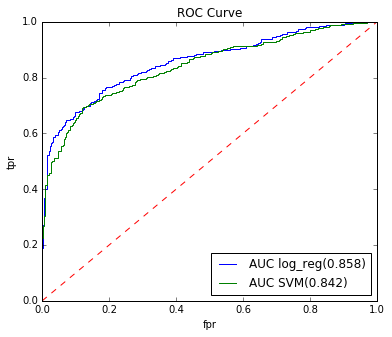

In [11]:
# Prediction for 2008 and 2009
#Data with <15 students
newdf = df[df.Count<15]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
i=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

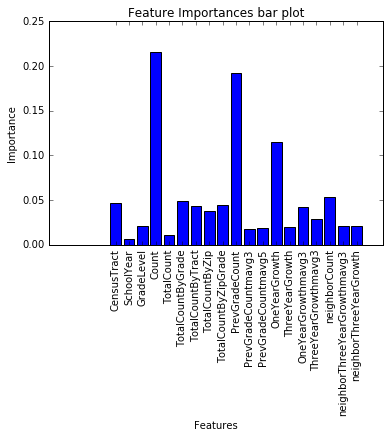

Top 5 most important features
1 Count 0.215735115846
2 PrevGradeCount 0.191797324246
3 OneYearGrowth 0.114334678339
4 neighborCount 0.0532532544628
5 TotalCountByGrade 0.0487187361015

Accuracy on train_df:  1.0
Accuracy on test_df:  0.667785234899


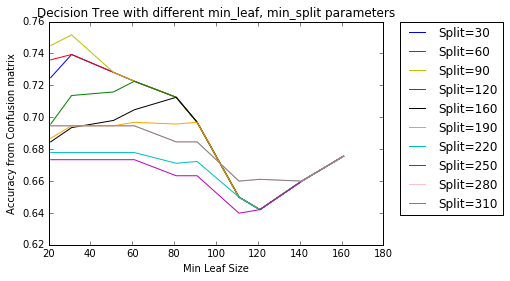

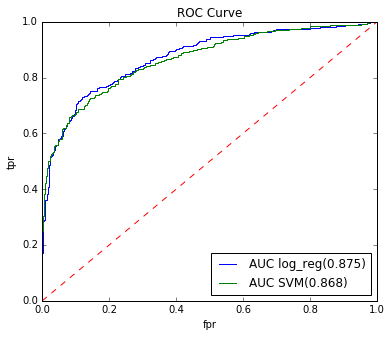

In [12]:
#Data with students >=15
newdf = df[df.Count>=15]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y
j=analysis(train_df_x, train_df_y, test_df_x, test_df_y)

In [13]:
from pandas.stats.api import ols
import math

def evaluation(result):
    diff = result.actual - result.newy
    ev = math.sqrt((diff**2).sum())
    return ev

In [22]:
df = pd.read_csv('cleantable-mb.csv')
df = df.fillna(0.0)
df = df[df.SchoolYear<2010]
df = df.drop(['Y','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns
corr = df.corr()
corr.Target.apply(abs).sort_values()

TotalCountByZip                 0.004110
TotalCountByGrade               0.008569
CensusTract                     0.012369
neighborThreeYearGrowth         0.012536
TotalCountByZipGrade            0.017939
GradeLevel                      0.018627
neighborCount                   0.025208
neighborThreeYearGrowthmavg3    0.028348
TotalCount                      0.034462
PrevGradeCountmavg5             0.044500
PrevGradeCountmavg3             0.049107
TotalCountByTract               0.053611
SchoolYear                      0.105232
Count                           0.121372
ThreeYearGrowthmavg3            0.122434
PrevGradeCount                  0.169062
OneYearGrowthmavg3              0.173810
ThreeYearGrowth                 0.191947
OneYearGrowth                   0.216183
Target                          1.000000
Name: Target, dtype: float64

In [36]:
df = pd.read_csv('cleantable-mb.csv')
df = df[df.SchoolYear<2010]
df = df.fillna(0.0)
df = df.drop(['Y','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns
test_df = df[df.SchoolYear>2008] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2008] # Training set from 2001 to 2007
#['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','OneYearGrowthmavg3']
res = ols(y=train_df['Target'], x=train_df.drop('Target',axis=1))

newy=(test_df.drop('Target',axis=1).dot(res.beta.drop('intercept')) + res.beta['intercept'])
newy = newy.apply(int)
result = pd.DataFrame({"newy": newy,"actual":test_df['Target']})
result.sum(axis=0)
evaluation(result)

C:\Users\jbak\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


181.04695523537532

In [15]:
df = pd.read_csv('cleantable-mb.csv')
df = df[df.SchoolYear<2010]
df = df.fillna(0.0)
df = df.drop(['Y','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns
test_df = df[df.SchoolYear>2007] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2007] # Training set from 2001 to 2007

res = ols(y=train_df['Target'], x=train_df[['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','OneYearGrowthmavg3']])
newy=(test_df[['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','OneYearGrowthmavg3']].dot(res.beta.drop('intercept')) + res.beta['intercept'])
newy = newy.apply(int)
result = pd.DataFrame({"newy": newy,"actual":test_df['Target']})
result.sum(axis=0)
evaluation(result)

C:\Users\jbak\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


264.6355985123695

In [16]:
#Data with students >=10
newdf = df[df.Count<10]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007

res = ols(y=train_df['Target'], x=train_df[['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','TotalCountByZipGrade']])
newy=(test_df[['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','TotalCountByZipGrade']].dot(res.beta.drop('intercept')) + res.beta['intercept'])
newy = newy.apply(int)
result = pd.DataFrame({"newy": newy,"actual":test_df['Target']})
result.sum(axis=0)
evaluation(result)

C:\Users\jbak\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


64.20280367709809

In [18]:
newdf = df[df.Count>=10]
test_df = newdf[newdf.SchoolYear>2007] #Test set 2008, 2009
train_df = newdf[newdf.SchoolYear<=2007] # Training set from 2001 to 2007
#[['PrevGradeCount','Count','OneYearGrowth','TotalCountByTract','OneYearGrowthmavg3']]
res = ols(y=train_df['Target'].apply(abs), x=train_df.drop('Target',axis=1))
newy=(test_df.drop('Target',axis=1).dot(res.beta.drop('intercept')) + res.beta['intercept'])
newy = newy.apply(int)
result = pd.DataFrame({"newy": newy,"actual":test_df['Target']})
result.sum(axis=0)
evaluation(result)


C:\Users\jbak\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


303.3084238856547